In [1]:
import numpy as np
from scipy import integrate, linalg, optimize
from matplotlib import pyplot as plt 
from numba import njit


def takagi_cehn(H):
    sing_vs, Q = linalg.eigh(H)
    phase_mat = np.diag(
                [np.exp(-1.j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])

    return vs, Qp

def takagi_stra(N, tol=1e-13, rounding=13):
    r"""Autonne-Takagi decomposition of a complex symmetric (not Hermitian!) matrix.

    Note that singular values of N are considered equal if they are equal after np.round(values, tol).

    See :cite:`cariolaro2016` and references therein for a derivation.

    Args:
        N (array[complex]): square, symmetric matrix N
        rounding (int): the number of decimal places to use when rounding the singular values of N
        tol (float): the tolerance used when checking if the input matrix is symmetric: :math:`|N-N^T| <` tol

    Returns:
        tuple[array, array]: (rl, U), where rl are the (rounded) singular values,
            and U is the Takagi unitary, such that :math:`N = U \diag(rl) U^T`.
    """
    (n, m) = N.shape
    if n != m:
        raise ValueError("The input matrix must be square")
    if np.linalg.norm(N - np.transpose(N)) >= tol:
        raise ValueError("The input matrix is not symmetric")

    N = np.real_if_close(N)

    if np.allclose(N, 0):
        return np.zeros(n), np.eye(n)

    if np.isrealobj(N):
        # If the matrix N is real one can be more clever and use its eigendecomposition
        l, U = np.linalg.eigh(N)
        vals = np.abs(l)  # These are the Takagi eigenvalues
        phases = np.sqrt(np.complex128([1 if i > 0 else -1 for i in l]))
        Uc = U @ np.diag(phases)  # One needs to readjust the phases
        list_vals = [(vals[i], i) for i in range(len(vals))]
        list_vals.sort(reverse=True)
        sorted_l, permutation = zip(*list_vals)
        permutation = np.array(permutation)
        Uc = Uc[:, permutation]
        # And also rearrange the unitary and values so that they are decreasingly ordered
        return np.array(sorted_l), Uc

    v, l, ws = np.linalg.svd(N)
    w = np.transpose(np.conjugate(ws))
    rl = np.round(l, rounding)

    # Generate list with degenerancies
    result = []
    for k, g in groupby(rl):
        result.append(list(g))

    # Generate lists containing the columns that correspond to degenerancies
    kk = 0
    for k in result:
        for ind, j in enumerate(k):  # pylint: disable=unused-variable
            k[ind] = kk
            kk = kk + 1

    # Generate the lists with the degenerate column subspaces
    vas = []
    was = []
    for i in result:
        vas.append(v[:, i])
        was.append(w[:, i])

    # Generate the matrices qs of the degenerate subspaces
    qs = []
    for i in range(len(result)):
        qs.append(sqrtm(np.transpose(vas[i]) @ was[i]))

    # Construct the Takagi unitary
    qb = block_diag(*qs)

    U = v @ np.conj(qb)
    return rl, U

def fdt_real(omega, t):
    t = np.array([t], dtype=np.float128)
    if ((omega - chemical_potential) / T) <= 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - band_center)**2 + band_width**2)\
              / (1.0 + np.exp( (omega - chemical_potential) / T ))
    elif ((omega - chemical_potential) / T) > 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.real

def fdt_imag(omega, t):
    t = np.array([t], dtype=np.float128)
    if ((omega - chemical_potential) / T) <= 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - band_center)**2 + band_width**2)\
              / (1.0 + np.exp( (omega - chemical_potential) / T ))
    elif ((omega - chemical_potential) / T) > 50:
        fun = np.exp(1.j * omega * t[0]) \
              * (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun.imag

def Jfermi_exact(omega):
    if ((omega - chemical_potential) / T) <= 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / (((omega - chemical_potential) - band_center)**2 + band_width**2)\
              / (1.0 + np.exp( (omega - chemical_potential) / T ))
    elif ((omega - chemical_potential) / T) > 50:
        fun = 1.0 * (0.5 * sys_bath_coupling * (band_width**2)) / (((omega - chemical_potential) - band_center)**2 + band_width**2)\
              / 10e+22
    #print('C(w,t)',omega,t,fun)
    return fun

def fermi_by_pade(omega):
    result = 0.5
    for j in range(num_pade):
        result = result + tilde_eta[j] / ((omega - chemical_potential) / T + pole[j]) \
                        + tilde_eta[j] / ((omega - chemical_potential) / T - pole[j])
    return result

@njit()
def J_fit(omega, fun, rate, eta):
    for i in range(len(rate)):
        fun = fun + eta[i] / (rate[i] + 1.j * (omega - chemical_potential) )
    return fun

@njit()      
def T_fit(tt, fun, rate, eta):
    for k in range(len(rate)):
        fun = fun + eta[k] * np.exp(-1 * rate[k] * tt)
    return fun

In [2]:
# the information of calculation paratemers
hbar = 0.658211928
omega_max = 100.0
omega_min = -100.0
omega_sample = 5000 + 1
omega = np.linspace(omega_min, omega_max, omega_sample)

time_max = 400.0
time_min = -400.0
time_sample = 4000 + 1
tt = np.linspace(time_min, time_max, time_sample)

tt_for_corr_min = 0.0
tt_for_corr_max = 10.0
time_sample_for_corr =  1000 + 1
tt_for_corr = np.linspace(tt_for_corr_min, tt_for_corr_max, time_sample_for_corr)

bath_corr_psd = np.zeros(time_sample_for_corr, dtype=complex)
bath_corr_exact = np.zeros(time_sample_for_corr, dtype = complex)
bath_corr_exact_real = np.zeros(time_sample_for_corr)
bath_corr_exact_imag = np.zeros(time_sample_for_corr)
bath_corr_exact_freq = np.zeros(omega_sample, dtype = complex)

print('Done!')

Done!


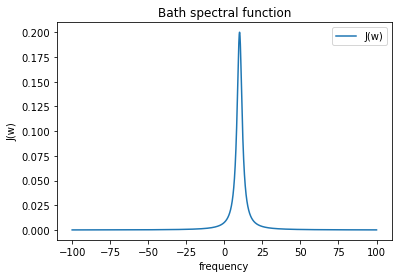

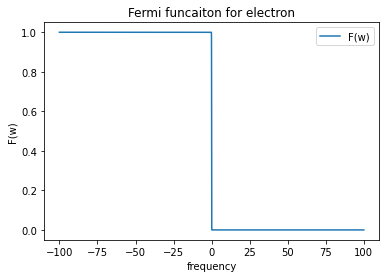

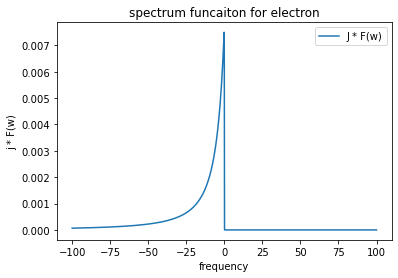

spectral_pole 
 (2-10j)
spectral_eta 
 (5.672250919484097e-218+3.330824670182747e-218j)


In [3]:
# the information of fermi funcaiton
T = 0.02                 #eV
chemical_potential = 0.0 #ev

fermi = np.zeros(omega_sample)
for i in range(omega_sample):
    if ((omega[i] - chemical_potential) / (T)) <= 50 :
        fermi[i] = 1.0 / ( 1.0 + np.exp( (omega[i] - chemical_potential) / (T) ) )
    elif ((omega[i] - chemical_potential) / (T)) > 50 :
        fermi[i] = 1.0 / 10e+22

# the information of bath spectral funcation
# the Lorentz type J(w) = 0.5 * sys_bath_coupling * band_width**2 / ( (w - band_center)**2 + band_width**2)
sys_bath_coupling = 0.4  #eV, is equal to HEOM-QUICK
band_width = 2.0         #eV
band_center = 10.0       #eV
bath_spectral = np.zeros(omega_sample, dtype=complex)
bath_spectral = (0.5 * sys_bath_coupling * (band_width**2)) / ((omega - band_center)**2 + band_width**2)
spectral_diss_rate = (band_width - 1.j * band_center) / hbar
spectral_eta = 0.5 * sys_bath_coupling * band_width \
                / ( 1.0 + np.exp((1.j * spectral_diss_rate - chemical_potential) * hbar / T )) / hbar**2

plt.title("Bath spectral function") 
plt.xlabel("frequency") 
plt.ylabel("J(w)") 
plt.plot(omega, bath_spectral.real, label = 'J(w)')
plt.legend(loc=1)
plt.show()

plt.title("Fermi funcaiton for electron") 
plt.xlabel("frequency") 
plt.ylabel("F(w)") 
plt.plot(omega, fermi.real, label = 'F(w)')
plt.legend(loc=1)
plt.show()

plt.title("spectrum funcaiton for electron") 
plt.xlabel("frequency") 
plt.ylabel("j * F(w)") 
plt.plot(omega, bath_spectral.real * fermi.real, label = 'J * F(w)')
plt.legend(loc=1)
plt.show()


bath_corr_exact_freq = bath_spectral * fermi

print('spectral_pole \n', spectral_diss_rate * hbar)
print('spectral_eta \n', spectral_eta)


#the Matsubara scheme
#num_mats = 1001
#mats = np.linspace(-(num_mats - 1)/2, (num_mats - 1)/2, num_mats, dtype = np.complex128)
#fermi_mats = np.zeros(omega_sample, dtype = np.complex128)
#bath_corr_msd = np.zeros(time_sample, dtype=np.complex128)

# for i in range(num_mats):
#     mats[i] = (mats[i] * 2 + 1) * np.pi * complex(0,1.0)

# for i in range(omega_sample):
#     fermi_mats[i] = 0.5
#     for j in range(num_mats):
#        fermi_mats[i] = fermi_mats[i] + 1.0 / (mats[j] - omega[i]/T)

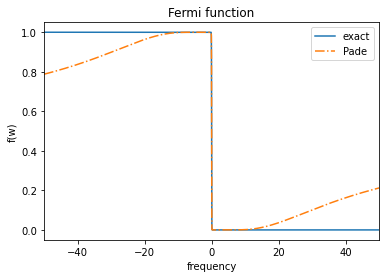

In [4]:
#the Pade scheme
num_pade = 20
b = np.zeros(2 * num_pade)
mat_xi = np.zeros((2 * num_pade, 2 * num_pade))
mat_varsigma = np.zeros((2 * num_pade - 1, 2 * num_pade - 1))
tilde_eta = np.zeros(num_pade, dtype = complex)         # namely cpcoef in evaluatepara.f90 
pole = np.zeros(num_pade, dtype = complex)              # namely cppole in evaluatepara.f90



for i in range(2 * num_pade):
    b[i] = 2 * (i) + 1

for i in range(2 * num_pade):
    for j in range(2 * num_pade):
        if (i == j-1 or i == j+1) :
            mat_xi[i,j] = 1.0 / np.sqrt(b[i] * b[j])

eigval_xi, eigvec_xi = np.linalg.eig(mat_xi) 
eigval_xi = np.sort(eigval_xi)
            
for i in range(2 * num_pade -1):
    for j in range(2 * num_pade -1):
        if (i == j-1 or i == j+1) :
            mat_varsigma[i,j] = 1.0 / np.sqrt(b[i+1] * b[j+1])

eigval_varsigma, eigvec_varsigma = np.linalg.eig(mat_varsigma)
eigval_varsigma = np.sort(eigval_varsigma)


for i in range(num_pade):
    pole[i] = (0. +2.j) / abs(eigval_xi[i])
    eigval_xi[i] = 4.0 / eigval_xi[i]**2
for i in range(num_pade-1):
    eigval_varsigma[i] = 4.0 / eigval_varsigma[i]**2

for i in range(num_pade):
    tilde_eta[i] = 0.5 * num_pade * (2 * num_pade + 1)
    for j in range(i):
        tilde_eta[i] = tilde_eta[i] * (eigval_varsigma[j] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
    for j in range(i+1,num_pade):
        tilde_eta[i] = tilde_eta[i] * (eigval_varsigma[j-1] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
    tilde_eta[i] = (-1. +0.j) * tilde_eta[i]

fermi_pade = np.zeros(omega_sample, dtype = np.complex128)
for i in range(omega_sample):
    fermi_pade[i] = 0.5
    for j in range(num_pade):
        fermi_pade[i] = fermi_pade[i] + tilde_eta[j] / ((omega[i] - chemical_potential) / T + pole[j]) \
                                      + tilde_eta[j] / ((omega[i] - chemical_potential) / T - pole[j])

        
plt.title("Fermi function") 
plt.xlabel("frequency") 
plt.ylabel("f(w)") 
plt.plot(omega, fermi, label = 'exact')
#plt.plot(omega, fermi_mats.real, label = 'Matsubara', linestyle = '--')
plt.plot(omega, fermi_pade.real, label = 'Pade', linestyle = '-.')
plt.legend(loc=1)
plt.xlim(chemical_potential-50,chemical_potential+50)
plt.show()

In [5]:
# Here we test the nalf = 1, spin = ↑, norbs = 1 and nsgn = (+ or 1). 
# the coefficients eta and gamma only sum over the number of poles.
eta_pade = np.zeros(num_pade + 1, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate_pade = np.zeros(num_pade + 1, dtype = complex)         # namely cgamma in evaluatepara.f90

spectral_diss_rate_pade = (band_width - 1.j * band_center) / hbar
spectral_eta_pade = 0.5 * sys_bath_coupling * band_width \
                   * fermi_by_pade((1.j * spectral_diss_rate - chemical_potential) * hbar) / hbar**2

diss_rate_pade[0] = spectral_diss_rate_pade
eta_pade[0] = spectral_eta_pade

for i in range(1, num_pade + 1):
    diss_rate_pade[i] = -1.j * T * pole[i - 1] / hbar
    eta_pade[i] = 2.j * tilde_eta[i - 1] * sys_bath_coupling * 0.5 * band_width**2 * T \
             / ( (pole[i - 1] * T - band_center)**2 + band_width**2 ) / hbar**2

print('pade_diss_rate \n', -1 * diss_rate_pade * hbar)
print('pade_eta \n', eta_pade)
print('pade_eta * hbar**2 \n', eta_pade * hbar**2)

pade_diss_rate 
 [ -2.        +10.j  -0.06283185 +0.j  -0.18849556 +0.j  -0.31415927 +0.j
  -0.43982297 +0.j  -0.56548668 +0.j  -0.69115038 +0.j  -0.81681409 +0.j
  -0.9424778  +0.j  -1.0681415  +0.j  -1.19380535 +0.j  -1.31949279 +0.j
  -1.44619637 +0.j  -1.58443278 +0.j  -1.76495399 +0.j  -2.02608389 +0.j
  -2.42072165 +0.j  -3.05905273 +0.j  -4.22944946 +0.j  -6.99190012 +0.j
 -20.89157037 +0.j]
pade_eta 
 [5.32336293e-04+0.00161477j 8.58086822e-06-0.00071013j
 2.57281785e-05-0.00070952j 4.28322672e-05-0.00070829j
 5.98645099e-05-0.00070646j 7.67965658e-05-0.00070402j
 9.36004881e-05-0.00070099j 1.10248832e-04-0.00069736j
 1.26714761e-04-0.00069316j 1.42972145e-04-0.00068839j
 1.58996734e-04-0.00068307j 1.74911437e-04-0.00067777j
 1.95448278e-04-0.00068863j 2.52202959e-04-0.00080773j
 3.88991285e-04-0.00111174j 6.48154663e-04-0.00159785j
 1.16406553e-03-0.00235966j 2.34652417e-03-0.00362989j
 5.62458265e-03-0.00572584j 1.68042093e-02-0.00662292j
 3.59552069e-02+0.02860863j]
pade_eta

In [6]:
# compare the pade results and the exact correlation function in time domain
# exact results

# for i in range(time_sample_for_corr):
#     bath_corr_exact_real[i],err = integrate.quad(fdt_real, a = -100, b = 100, args=(tt_for_corr[i]), limit = 20000)
#     bath_corr_exact_imag[i],err = integrate.quad(fdt_imag, a = -200, b = 200, args=(tt_for_corr[i]), limit = 10000)
#     bath_corr_exact[i] = complex(bath_corr_exact_real[i], bath_corr_exact_imag[i])

# print('Done!')

In [7]:
# pade results
for i in range(time_sample_for_corr):
    for j in range(num_pade + 1):
        bath_corr_psd[i] = bath_corr_psd[i] + eta_pade[j] * hbar**2 * np.exp(-1 * diss_rate_pade[j] * hbar * tt_for_corr[i])

print('Done!')

Done!


In [8]:
dimension_Hankel = 1500
num_prony = 10

tt_for_prony_min = 0.0
tt_for_prony_max = 80.0
time_sample_for_prony =  2 * dimension_Hankel + 1
tt_for_prony = np.linspace(tt_for_prony_min, tt_for_prony_max, time_sample_for_prony)
hankel_matrix_real = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
hankel_matrix_imag = np.zeros((dimension_Hankel + 1, dimension_Hankel + 1))
phi = np.zeros(time_sample_for_prony,dtype=complex)

phi = T_fit(tt_for_prony, phi, diss_rate_pade * hbar, eta_pade * hbar**2)

print("phi.real\n",phi[2980:].real)
print("phi.imag\n",phi[2980:].imag)
       
print('Done!')

phi.real
 [2.52274792e-08 2.51852340e-08 2.51430595e-08 2.51009556e-08
 2.50589223e-08 2.50169594e-08 2.49750669e-08 2.49332445e-08
 2.48914922e-08 2.48498099e-08 2.48081973e-08 2.47666546e-08
 2.47251814e-08 2.46837777e-08 2.46424433e-08 2.46011783e-08
 2.45599823e-08 2.45188554e-08 2.44777974e-08 2.44368081e-08
 2.43958876e-08]
phi.imag
 [-2.08756918e-06 -2.08407403e-06 -2.08058474e-06 -2.07710128e-06
 -2.07362367e-06 -2.07015187e-06 -2.06668589e-06 -2.06322571e-06
 -2.05977133e-06 -2.05632273e-06 -2.05287991e-06 -2.04944285e-06
 -2.04601155e-06 -2.04258599e-06 -2.03916617e-06 -2.03575207e-06
 -2.03234370e-06 -2.02894103e-06 -2.02554406e-06 -2.02215277e-06
 -2.01876717e-06]
Done!


In [9]:
def prony(res_t, num_prony, scale, n): 
    # input a array of reservoir correlation funcation C(t) at different times
    # build the Hankel matrix
    n_sample = n + 1
    print(n_sample)
    n_gamma = num_prony
    h = np.imag(res_t)
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    
    # takagi factoriziation for imagnary part Im[C(t)]
    sing_vs, Q = linalg.eigh(H)
    phase_mat = np.diag(
        [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])   
    print("error of decompose", np.sum(np.abs(H -
                   np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    del H
    gamma = np.roots(Qp[:, num_prony][::-1])
    tmp_index = gamma != 0
    gamma = gamma[tmp_index]
    gamma_new = gamma[np.argsort(np.abs(gamma))[:num_prony]]
    t_imag = 2 * n * np.log(gamma_new)
    gamma_m = np.zeros((n_sample * 2 - 1, num_prony), dtype=complex)
    for i in range(num_prony):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_imag = np.dot(linalg.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                        np.dot(np.transpose(gamma_m), np.transpose(h)))
    plt.scatter(np.real(gamma),np.imag(gamma))
    plt.scatter(np.real(gamma_new),np.imag(gamma_new))
    plt.show()
    print("prony: takagi decompostion for imagnary part:\n", gamma_new)
    
    # takagi factoriziation for real part Re[C(t)]
    h = np.real(res_t)
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    sing_vs, Q = linalg.eigh(H)
    
    phase_mat = np.diag(
    [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    print(
        "error of decompose",
        np.sum(np.abs(H -
                  np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    
    gamma = np.roots(Qp[:, num_prony][::-1])
    tmp_index = gamma != 0
    gamma = gamma[tmp_index]
    print("para")
    print(Qp[:, num_prony][::-1])
    
    gamma_new = gamma[np.argsort(np.abs(gamma))[:num_prony]]
    t_real = 2 * n * np.log(gamma_new)
    gamma_m = np.zeros((n_sample * 2 - 1, num_prony), dtype=complex)
    for i in range(num_prony):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_real = np.dot(linalg.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                        np.dot(np.transpose(gamma_m), np.transpose(h)))
    plt.scatter(np.real(gamma),np.imag(gamma))
    plt.scatter(np.real(gamma_new),np.imag(gamma_new))
    plt.show()
    print("prony: takagi decompostion for real part:\n", gamma_new)
    
    eta = np.append(1.j * omega_imag, omega_real)
    diss_rate = np.append(-t_imag / scale, -t_real / scale)
    
    return eta, diss_rate

1501
error of decompose 1.39110338983339e-13


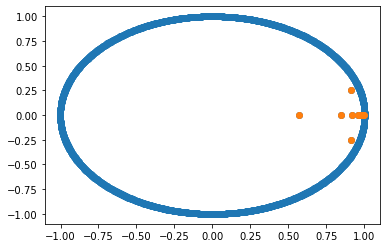

prony: takagi decompostion for imagnary part:
 [0.57220148+0.00000000e+00j 0.84477675-1.24362063e-16j
 0.92084325-3.67925250e-16j 0.91457055-2.49885342e-01j
 0.91457055+2.49885342e-01j 0.95986419+4.23342503e-16j
 0.97991013+2.27764978e-15j 0.98986518-5.12809349e-15j
 0.99486293+2.41148885e-15j 0.9983253 +1.55431223e-15j]
error of decompose 1.2418810280508953e-14
para
[ 0.01165283+0.j  0.01166853+0.j  0.01168423+0.j ... -0.11799893+0.j
 -0.12227173+0.j  0.1026286 +0.j]


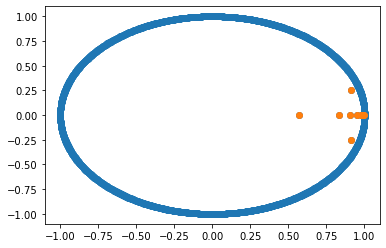

prony: takagi decompostion for real part:
 [0.57302495+0.00000000e+00j 0.83268036+1.46851601e-16j
 0.908073  +4.52255125e-16j 0.91454001+2.49829186e-01j
 0.91454001-2.49829186e-01j 0.95093392-1.37757288e-15j
 0.9752912 -1.74038304e-15j 0.98812536+2.90947372e-15j
 0.99455486-2.58038724e-15j 0.99831724+1.66533454e-15j]
Done!
diss_rate_prony
 [20.93490406-0.00000000e+00j  6.32560812+5.52048497e-15j
  3.09245462+1.49832199e-14j  1.99881627+1.00018911e+01j
  1.99881627-1.00018911e+01j  1.53613021-1.65391563e-14j
  0.76104054-8.71629593e-14j  0.38199473+1.94272422e-13j
  0.19313671-9.08977803e-14j  0.06285404-5.83844855e-14j
 20.88097555-0.00000000e+00j  6.86645379-6.61350420e-15j
  3.6161441 -1.86764360e-14j  2.00056681-1.00000667e+01j
  2.00056681+1.00000667e+01j  1.88665134+5.43244718e-14j
  0.93821966+6.69178234e-14j  0.44796384-1.10416419e-13j
  0.20475074+9.72943027e-14j  0.06315658-6.25553106e-14j]
eta_prony
 [ 7.13133507e-16+1.23270529e-02j -4.13500631e-15-3.90657762e-03j
  4.7009760

In [10]:
bath_corr_prony = np.zeros(time_sample_for_corr, dtype=complex)

eta_prony = np.zeros(2 * num_prony , dtype = complex)
diss_rate_prony = np.zeros(2 * num_prony, dtype = complex)

eta_prony, diss_rate_prony = prony(phi, num_prony, 80, dimension_Hankel)

for i in range(time_sample_for_corr):
    for j in range(2 * num_prony):
        bath_corr_prony[i] = bath_corr_prony[i] + eta_prony[j] * np.exp(-1 * diss_rate_prony[j] * tt_for_corr[i])

print('Done!')

print("diss_rate_prony\n", diss_rate_prony)
print("eta_prony\n", eta_prony)

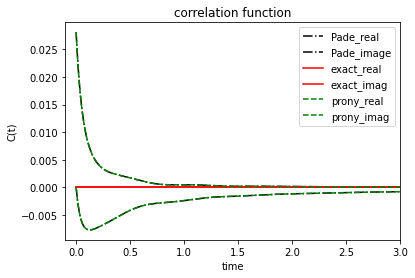

In [11]:
plt.title("correlation function") 
plt.xlabel("time") 
plt.ylabel("C(t)") 
plt.plot(tt_for_corr, bath_corr_psd.real, label = 'Pade_real', linestyle = '-.', color = 'k') 
plt.plot(tt_for_corr, bath_corr_psd.imag, label = 'Pade_image', linestyle = '-.', color = 'k') 
plt.plot(tt_for_corr, bath_corr_exact_real, label = 'exact_real', color = 'r') 
plt.plot(tt_for_corr, bath_corr_exact_imag, label = 'exact_imag', color = 'r') 
plt.plot(tt_for_corr, bath_corr_prony.real, label = 'prony_real', linestyle = '--', color = 'g')
plt.plot(tt_for_corr, bath_corr_prony.imag, label = 'prony_imag', linestyle = '--', color = 'g')
plt.legend(loc=1)
plt.xlim(-0.1, 3)
plt.show()

In [12]:
bath_corr_psd_freq = np.zeros(omega_sample, dtype = complex)
#bath_corr_prony_imag_freq = np.zeros(omega_sample, dtype = complex)
#bath_corr_prony_real_freq = np.zeros(omega_sample, dtype = complex)
bath_corr_prony_freq = np.zeros(omega_sample, dtype = complex)

bath_corr_psd_freq = J_fit(omega, bath_corr_psd_freq, diss_rate_pade * hbar, eta_pade * hbar**2)
bath_corr_prony_freq = J_fit(omega, bath_corr_prony_freq, diss_rate_prony, eta_prony)
#bath_corr_prony_imag_freq[i] = J_fit(omega_freq[i], diss_rate_prony_imag, eta_prony_imag)
#bath_corr_prony_real_freq[i] = J_fit(omega_freq[i], diss_rate_prony_real, eta_prony_real)

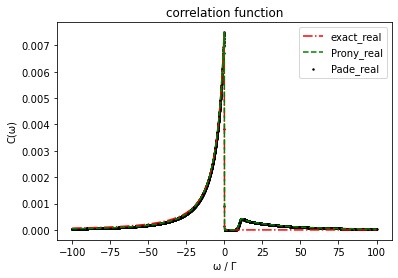

 -0.03999999999999204 
 psd   0.006723539167171784 
 exact 0.006723539167171815 
 prony 0.006723555614562872

 0.0 
 psd   0.0038461538461538438 
 exact 0.0038461538461538464 
 prony 0.0038461454516596516

 0.04000000000000625 
 psd   0.0009240393328947483 
 exact 0.0009240393328947215 
 prony 0.0009240388978780704


In [13]:
plt.title("correlation function") 
plt.xlabel("ω / Γ") 
plt.ylabel("C(ω)")
plt.scatter(omega, bath_corr_psd_freq.real, label = 'Pade_real', s = 2, color = 'k')
plt.plot(omega, bath_corr_exact_freq.real, label = 'exact_real', linestyle = '-.', color = 'r')
plt.plot(omega, bath_corr_prony_freq.real, label = 'Prony_real', linestyle = '--', color = 'g')
plt.legend(loc=1)
#plt.xlim(-25, 25)
#plt.ylim(-0.01, 0.01)
plt.show()

x = 2500
a = max(np.abs(bath_corr_psd_freq.real))
b = max(np.abs(bath_corr_exact_freq.real))
c = max(np.abs(bath_corr_prony_freq.real))
print('',omega[x-1],'\n psd  ',(bath_corr_psd_freq[x-1]).real,'\n exact',bath_corr_exact_freq[x-1],\
      '\n prony',(bath_corr_prony_freq[x-1]).real)
print()
print('',omega[x],'\n psd  ',(bath_corr_psd_freq[x]).real,'\n exact',bath_corr_exact_freq[x],\
      '\n prony',(bath_corr_prony_freq[x]).real)
print()
print('',omega[x+1],'\n psd  ',(bath_corr_psd_freq[x+1]).real,'\n exact',bath_corr_exact_freq[x+1],\
      '\n prony',(bath_corr_prony_freq[x+1]).real)